# Homework 1: Classifiers

# Linear Support Vector Machine (SVM) classifier

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Load and preprocess CIFAR-10 dataset

In [2]:
from keras.datasets import cifar10

def get_CIFAR10_data(num_training=49000, num_validation=1000,
                     num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    # All the data comes in the uint8 format, so we need to convert
    # it to floats so that we compute numbers greater than 255.
    X_train = X_train.astype(np.float)
    X_test = X_test.astype(np.float)
    # Also, for convenience we flatten the class arrays.
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    # Split the data into train, val, and test sets. In addition we will
    # create a small development set as a subset of the training data;
    # we can use this for development so our code runs faster.
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    
    # Our training set will be the first num_train points from the original
    # training set.
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    # We will also make a development set, which is a small subset of
    # the training set.
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # We use the first num_test points of the original test set as our
    # test set.
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # third: append the bias dimension of ones (i.e. bias trick) so that our SVM
    # only has to worry about optimizing a single weight matrix W.
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

170508288/170498071 [==============================] - 3s 0us/step
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Define a naive SVM classifier loss function

Next we define the SVM loss function.  This will be a naive implementation using loops.  Most of the code for this loss function already exists, but you will need to write code of your own to finish it.  Follow the instructions in the TODO section.

Recall that the contribution of a training point $(x_i, y_i)$ to the SVM loss function is

$$L_i = \sum_{j \neq y_i} \max(0, s_j− s_{y_i} + \Delta)$$

where $\Delta$ is the *margin*.  The loss function encourages the score $s_{y_i}$ of the correct class $y_i$ to be larger than any of the other scores $s_j$ by at least the margin $\Delta$.  The score $s$ is parametrized by
a linear function $s_j = xW_j$ where $x$ is a single data sample and $W_j$ is the $j$th column of $W$.

![margin](http://cs231n.github.io/assets/margin.jpg)

In [3]:
def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.shape) # initialize the gradient as zero

  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in range(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    for j in range(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1
      if margin > 0:
        # Add to loss
        loss += margin

        # Contributions to the gradient wrt to correct class weights
        # (Note: Is summing over each class that contributed to loss 
        # function and because of continue statement above will exclude j=y[i]) 
        dW[:, y[i]] += -(X[i,:])

        # Contributions to the gradient wrt to other class weights 
        dW[:, j] += (X[i,:])

      # else: loss is 0, and no contribution to gradient 

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train
  loss /= num_train

  # Also scale gradient because of how we scaled loss (Okay because linearity of gradient operator)
  dW /= num_train

  # Add regularization to the loss
  loss += reg * np.sum(W * W)

  # Regularize gradient as well (derivative of L2 regularization) 
  dW += 2 * reg * W 

  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it dW.                #
  # Rather than first computing the loss and then computing the derivative,   #
  # it may be simpler to compute the derivative at the same time that the     #
  # loss is being computed. As a result you may need to modify some of the    #
  # code above to compute the gradient.                                       #
  #############################################################################


  return loss, dW

In [4]:
# Evaluate the naive implementation of the SVM loss
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.963839


To check that you have implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [5]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in range(num_checks):
    ix = tuple([np.random.randint(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))
    
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -17.858944 analytic: -17.858944, relative error: 1.099875e-11
numerical: 29.297082 analytic: 29.297082, relative error: 2.483388e-12
numerical: 18.485788 analytic: 18.485788, relative error: 8.819810e-12
numerical: 7.106779 analytic: 7.106779, relative error: 3.584106e-11
numerical: 10.874112 analytic: 10.874112, relative error: 8.072179e-12
numerical: 5.677731 analytic: 5.677731, relative error: 4.613670e-11
numerical: 26.311517 analytic: 26.311517, relative error: 7.757054e-12
numerical: 14.443635 analytic: 14.443635, relative error: 7.263028e-12
numerical: -47.937879 analytic: -47.937879, relative error: 4.219349e-12
numerical: -14.900721 analytic: -14.900721, relative error: 8.449685e-12
numerical: 8.872691 analytic: 8.872691, relative error: 7.457736e-12
numerical: 16.909830 analytic: 16.909830, relative error: 3.849470e-11
numerical: 11.950451 analytic: 11.950451, relative error: 1.180319e-11
numerical: -1.329887 analytic: -1.329887, relative error: 5.279442e-10
numeri

### Inline Question 1:
It is possible that once in a while a value in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** 

The differences can be first attributed to how numerical differentiation is a discrete approximation to a continuous thing. This means the method itself inherently has error. A second thing is the difference between how we are doing floating point arithmetic in the computer differently. The operations that comprise calculating the analytical gradient are subject to different floating point error than the operations that comprise the numerical gradient.

An example of a difference between the methods is that the SVM loss function (hinge loss) is discontinous at the margin point thus near this point the numerical gradient will be affected more by the sudden change in the function where the analytical gradient wouldn't be affected at all (unless you choose exactly the margin then it has an undefined gradient).

In the end this is not a cause for too much concern as long as the values are reasonably close we can assume the gradients are equivalent.

## Define a vectorized SVM classifier loss function

Next we define the vectorized (i.e. no loops) version of the SVM loss function.  Most of the code for this loss function already exists, but you will need to write code of your own to finish it.  Follow the instructions in the TODO section.

In [6]:
def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero

  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized form of the SVM loss, storing the result in loss.  #
  #                                                                           #
  #############################################################################
  num_train = X.shape[0]
  num_classes = W.shape[1]
  all_class_scores = np.dot(X,W)
  # Scores of correct labels for each training data point, turned into column vector
  correct_class_scores = (all_class_scores[np.arange(num_train), y])[:,np.newaxis] 
  all_margins = np.maximum(0, all_class_scores-correct_class_scores+1)
  # We can't count when comparing against same class
  all_margins[np.arange(num_train), y] = 0
  # Sum all margins to compute loss
  loss = np.sum(all_margins)
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the SVM loss,          #
  # storing the result in dW.                                                 #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################
  X_mask = np.zeros_like(all_margins)

  # Will select all margin values that are non-zero 
  # (When multipled by training examples "correctly" will be the contributions to the gradient wrt to other class weights )
  X_mask[all_margins > 0] = 1

  # Sum non-zero margin values for each class and place in correct class slot for each example
  # (When multiplied by training examples "correctly" will be summing contributions to the gradient wrt to correct class weights)
  # (Note: Is summing over each class that contributed to loss function)
  X_mask[np.arange(num_train), y] = -np.sum(X_mask, axis=1) 

  # Multiply "correctly" 
  dW = np.dot(X.T, X_mask)

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train
  loss /= num_train

  # Also scale gradient because of how we scaled loss (Okay because linearity of gradient operator)
  dW /= num_train

  # Add regularization to the loss
  loss += reg * np.sum(W * W)

  # Regularize gradient as well (derivative of L2 regularization) 
  dW += 2 * reg * W 
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return loss, dW

In [7]:
# Evaluate the naive implementation of the SVM loss
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

# Evaluate the vectorized implementation of the SVM loss
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.963839e+00 computed in 0.171525s
Vectorized loss: 8.963839e+00 computed in 0.019367s
difference: 0.000000


In [8]:
# Evaluate the naive implementation of the SVM gradients

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.204019s
Vectorized loss and gradient: computed in 0.012719s
difference: 0.000000


## Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.  Follow the instructions in the TODO sections.

In [9]:
class SVM(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO:                                                                 #
      # Sample batch_size elements from the training data and their           #
      # corresponding labels to use in this round of gradient descent.        #
      # Store the data in X_batch and their corresponding labels in           #
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
      # and y_batch should have shape (batch_size,)                           #
      #                                                                       #
      # Hint: Use np.random.choice to generate indices. Sampling with         #
      # replacement is faster than sampling without replacement.              #
      #########################################################################
      # I think they mean X_batch should have shape (batch_size, dim) 
      # i.e. X_batch: A numpy array of shape (N, D) containing a minibatch of N
      # data points; each point has dimension D
      batch_idxs = np.random.choice(num_train, batch_size)
      X_batch = X[batch_idxs, :]
      y_batch = y[batch_idxs]
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
      #########################################################################
      # TODO:                                                                 #
      # Update the weights using the gradient and the learning rate.          #
      #########################################################################
      self.W -= learning_rate * grad
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    y_pred = np.argmax(np.dot(X, self.W), axis=1)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [10]:
# Implement SGD in the function SVM.train() and then run it with the code below.
svm = SVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 791.122837
iteration 100 / 1500: loss 288.054084
iteration 200 / 1500: loss 108.150659
iteration 300 / 1500: loss 42.819352
iteration 400 / 1500: loss 18.696734
iteration 500 / 1500: loss 10.178137
iteration 600 / 1500: loss 7.242668
iteration 700 / 1500: loss 6.253951
iteration 800 / 1500: loss 5.396437
iteration 900 / 1500: loss 4.893221
iteration 1000 / 1500: loss 5.008493
iteration 1100 / 1500: loss 5.670215
iteration 1200 / 1500: loss 5.293479
iteration 1300 / 1500: loss 5.365654
iteration 1400 / 1500: loss 5.319569
That took 8.927934s


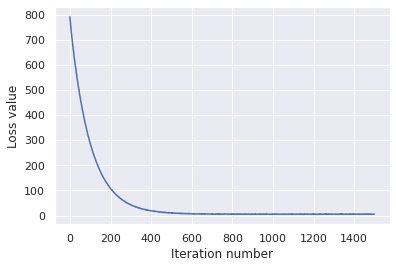

In [11]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [12]:
# Write the SVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.364612
validation accuracy: 0.378000


In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [5e-8, 1e-7, 5e-7]
regularization_strengths = [1e4, 4e4, 7e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
iters = 800
for lr_val in learning_rates:
  for reg_val in regularization_strengths:
    svm_val = SVM()
    svm_val.train(X_train, y_train, learning_rate=lr_val, reg=reg_val, num_iters=iters, verbose=False)
    y_train_pred = svm_val.predict(X_train)
    train_acc = np.mean(y_train_pred == y_train)
    y_val_pred = svm_val.predict(X_val)
    val_acc = np.mean(y_val_pred == y_val)
    results[(lr_val, reg_val)] = (train_acc, val_acc)
    if(val_acc > best_val):
      best_val = val_acc
      best_svm = svm_val


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-08 reg 1.000000e+04 train accuracy: 0.298612 val accuracy: 0.308000
lr 5.000000e-08 reg 4.000000e+04 train accuracy: 0.362429 val accuracy: 0.377000
lr 5.000000e-08 reg 7.000000e+04 train accuracy: 0.352857 val accuracy: 0.349000
lr 5.000000e-08 reg 1.000000e+05 train accuracy: 0.348163 val accuracy: 0.371000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.360408 val accuracy: 0.366000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.358490 val accuracy: 0.370000
lr 1.000000e-07 reg 7.000000e+04 train accuracy: 0.354878 val accuracy: 0.359000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.347429 val accuracy: 0.363000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.334776 val accuracy: 0.320000
lr 5.000000e-07 reg 4.000000e+04 train accuracy: 0.343918 val accuracy: 0.350000
lr 5.000000e-07 reg 7.000000e+04 train accuracy: 0.304367 val accuracy: 0.313000
lr 5.000000e-07 reg 1.000000e+05 train accuracy: 0.308918 val accuracy: 0.332000
best validation accuracy ach

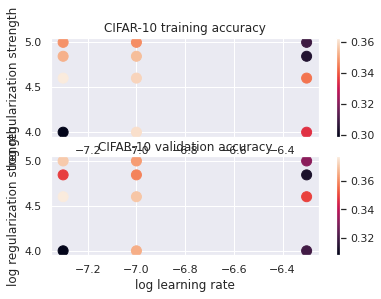

In [14]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [15]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.364000


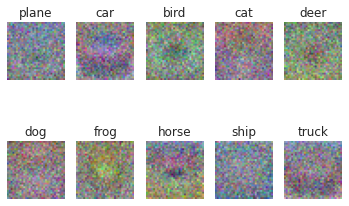

In [16]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** 

The SVM weights visually resemble certain characteristic features of their respective labels. For example the horse has the outline of horse maine and shape of a horse head along with grass, all common features of horse images. Another example is a car which vaguely has wheels and a gray road, all charactersitic parts of a car. Through training the SVM classifier was able to adjust the weights so the loss was minimized relative to the training set and thus it "learned" what are distinctive features of each class.

*Many thanks to Stanford CS231n for permission to use their materials!*